In [13]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, timedelta, timezone
import matplotlib as plot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import itertools as it
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical
#from keras.models import Sequential
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

In [78]:
#BTCUSDT_df = pd.read_csv('20250202 12.58.42.-20170908 12.58.42._BTC-USDT_1D_okx_ohlc.csv')
BTC_df = pd.read_csv('20250202 12.58.42.-20170908 12.58.42._BTC-USDT_1D_okx_ohlc_M.csv')
BNB_df = pd.read_csv('2025-01-27 23.34.10.711000-2017-09-07 23.34.10.711000_BNB-USDT_1H_ohlc_M.csv')
DOGE_df = pd.read_csv('20250202 12.58.42.-20170908 12.58.42._DOGE-USDT_1D_okx_ohlc_M.csv')
XRP_df = pd.read_csv('20250202 12.58.42.-20170908 12.58.42._XRP-USDT_1D_okx_ohlc_M.csv')


In [4]:
#RSI CALC
#modified from here https://rbdundas.medium.com/calculate-relative-strength-index-rsi-and-chart-with-candles-using-python-pandas-and-matplotlib-f58d926249ac

def get_up_or_down(df):
    for i in range(len(df)):
        if i > 0:
            if df.iloc[i]['close'] >= df.iloc[i-1]['close']:
                df.at[i, 'gain'] = df.iloc[i]['close'] - df.iloc[i-1]['close']
                df.at[i, 'loss'] = 0
            elif df.iloc[i]['close'] < df.iloc[i-1]['close']:
                df.at[i, 'loss'] = df.iloc[i-1]['close'] - df.iloc[i]['close']
                df.at[i, 'gain'] = 0
            else:
                df.at[i, 'gain'] = 0
                df.at[i, 'loss'] = 0
    return df

def get_up_or_down_bin(df, offset):
    for i in range(len(df)):
        if i > 0:
            if df.iloc[i]['close'] >= df.iloc[i-offset]['close']:
                df.at[i, 'updown'] = 1
            elif df.iloc[i]['close'] < df.iloc[i-offset]['close']:
                df.at[i, 'updown'] = -1                
            else:
                df.at[i, 'updown'] = 0
    return df
  
def get_relative_strength_index(df):
    df['Date'] = pd.to_datetime(df['timestamp'])
    df.set_index(df['Date'])
    df = get_up_or_down(df)
    return df

def get_average_gains(df, period):
    for i in range(len(df)):
        n, up, down = 0, 0, 0
        if i == period:
            while n < period:
                if df.iloc[i-n]['gain'] > 0:
                    up += df.iloc[i-n]['gain']
                elif df.iloc[i-n]['loss'] > 0:
                    down += df.iloc[i-n]['loss']
                else:
                    up += 0
                    down += 0
                n += 1
            df.at[i, 'ag'] = up/period
            df.at[i, 'al'] = down/period
        elif i > period:
            df.at[i, 'ag'] = (df.iloc[i-1]['ag'] * (period - 1) + df.iloc[i]['gain'])/period
            df.at[i, 'al'] = (df.iloc[i-1]['al'] * (period - 1) + df.iloc[i]['loss'])/period
            df['ag'] = df['ag'].fillna(0)
            df['al'] = df['al'].fillna(0)
    return df

def get_relative_strength(df, period):
    df = get_relative_strength_index(df)
    df = get_average_gains(df, period)
    for i in range(len(df)):
        if i >= period:
            df.at[i, 'rs'] = df.iloc[i]['ag']/df.iloc[i]['al']
            df.at[i, 'rsi'] = (100-(100/(1+df.iloc[i]['rs'])))
    return df

##MONEY FLOW
#modified from here https://www.quantifiedstrategies.com/how-to-build-a-profitable-money-flow-index-strategy-using-python/
def get_typical_price(high, low, close):
    typical_price = (high+low+close/3)
    return typical_price

def get_raw_money_flow(typical_price, volume):
    money_flow = typical_price * volume
    return money_flow

def get_money_flow_ratio(money_flow, window=14):
    signal = np.where(money_flow > money_flow.shift(1), 1, np.where(money_flow < money_flow.shift(1), -1, 0))
    money_flow_s = money_flow * signal
    
    money_flow_positive = money_flow_s.rolling(window).apply(lambda x: np.sum(np.where(x >= 0.0, x, 0.0)), raw=True)
    money_flow_negative = abs(money_flow_s.rolling(window).apply(lambda x: np.sum(np.where(x < 0.0, x, 0.0)), raw=True))
    
    money_flow_ratio = money_flow_positive / money_flow_negative
    
    return money_flow_ratio

def get_money_flow_index(money_flow_ratio):
    money_flow_index = 100. - 100./(1. + money_flow_ratio)
    return money_flow_index

def money_flow_index(high, low, close, volume, window=14):
    mfr = get_money_flow_ratio((high+low+close/3) * volume, window)
    mfi = 100. - 100./(1. + mfr)
    return mfi

#Choppiness index
#https://www.insightbig.com/post/detecting-ranging-and-trending-markets-with-choppiness-index-in-python
def get_ci(high, low, close, lookback):
    tr1 = pd.DataFrame(high - low).rename(columns = {0:'tr1'})
    tr2 = pd.DataFrame(abs(high - close.shift(1))).rename(columns = {0:'tr2'})
    tr3 = pd.DataFrame(abs(low - close.shift(1))).rename(columns = {0:'tr3'})
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').dropna().max(axis = 1)
    atr = tr.rolling(1).mean()
    highh = high.rolling(lookback).max()
    lowl = low.rolling(lookback).min()
    ci = 100 * np.log10((atr.rolling(lookback).sum()) / (highh - lowl)) / np.log10(lookback)
    return ci

In [107]:
BTC_df = get_relative_strength(BTC_df, 14)
BTC_df = get_relative_strength(BTC_df, 2)
BTC_df = get_up_or_down_bin(BTC_df, 1)


BTC_df['return'] = BTC_df['close'].pct_change()
BTC_df['range'] = BTC_df['high'] - BTC_df['low']
BTC_df['range%'] = BTC_df['range']/BTC_df['close']

BTC_df['std'] = BTC_df['return'].rolling(2).std()
BTC_df['std'] = BTC_df['return'].rolling(3).std()
BTC_df['std'] = BTC_df['return'].rolling(4).std()
BTC_df['std'] = BTC_df['return'].rolling(5).std()
BTC_df['std'] = BTC_df['return'].rolling(6).std()
BTC_df['std'] = BTC_df['return'].rolling(7).std()
BTC_df['std'] = BTC_df['return'].rolling(8).std()
BTC_df['std'] = BTC_df['return'].rolling(9).std()
BTC_df['std'] = BTC_df['return'].rolling(10).std()
BTC_df['std'] = BTC_df['return'].rolling(14).std()
BTC_df['std'] = BTC_df['return'].rolling(28).std()
BTC_df['std'] = BTC_df['return'].rolling(56).std()
BTC_df['std'] = BTC_df['return'].rolling(77).std()
BTC_df['std'] = BTC_df['return'].rolling(112).std()


BTC_df['ma14'] = BTC_df['close'].rolling(14).mean()
BTC_df['obv'] = (np.sign(BTC_df['close'].diff()) * BTC_df['volume_ccy']).fillna(0).cumsum()
BTC_df['mfi']= money_flow_index(BTC_df['high'], BTC_df['low'], BTC_df['close'], BTC_df['volume_ccy'], 14)


#7 day return, 14 day return, 28 day return, 56 day return, 112 day
#7 day avg volatility, 14 day avg volatility, 28 day avg volatility, 56 day avg volatility
#7 up/down day count, 14 day up/down day count, 28 day up/down day count, 56 day up/down day count
#7 day avg volume, 14 day avg volume, 28 day avg volume, 56 day avg volume
BTC_df['ma02'] = BTC_df['close'].rolling(2).mean()
BTC_df['ma03'] = BTC_df['close'].rolling(3).mean()
BTC_df['ma04'] = BTC_df['close'].rolling(4).mean()
BTC_df['ma05'] = BTC_df['close'].rolling(5).mean()
BTC_df['ma06'] = BTC_df['close'].rolling(6).mean()
BTC_df['ma07'] = BTC_df['close'].rolling(7).mean()
BTC_df['ma08'] = BTC_df['close'].rolling(8).mean()
BTC_df['ma09'] = BTC_df['close'].rolling(9).mean()
BTC_df['ma10'] = BTC_df['close'].rolling(10).mean()
BTC_df['ma14'] = BTC_df['close'].rolling(14).mean()
BTC_df['ma28'] = BTC_df['close'].rolling(28).mean()
BTC_df['ma56'] = BTC_df['close'].rolling(56).mean()
BTC_df['ma77'] = BTC_df['close'].rolling(77).mean()
BTC_df['ma112'] = BTC_df['close'].rolling(112).mean()

BTC_df['avgvolm02'] = BTC_df['volume_ccy'].rolling(2).mean()
BTC_df['avgvolm03'] = BTC_df['volume_ccy'].rolling(3).mean()
BTC_df['avgvolm04'] = BTC_df['volume_ccy'].rolling(4).mean()
BTC_df['avgvolm05'] = BTC_df['volume_ccy'].rolling(5).mean()
BTC_df['avgvolm06'] = BTC_df['volume_ccy'].rolling(6).mean()
BTC_df['avgvolm07'] = BTC_df['volume_ccy'].rolling(7).mean()
BTC_df['avgvolm08'] = BTC_df['volume_ccy'].rolling(8).mean()
BTC_df['avgvolm09'] = BTC_df['volume_ccy'].rolling(9).mean()
BTC_df['avgvolm10'] = BTC_df['volume_ccy'].rolling(10).mean()
BTC_df['avgvolm14'] = BTC_df['volume_ccy'].rolling(15).mean()
BTC_df['avgvolm28'] = BTC_df['volume_ccy'].rolling(25).mean()
BTC_df['avgvolm56'] = BTC_df['volume_ccy'].rolling(50).mean()
BTC_df['avgvolm77'] = BTC_df['volume_ccy'].rolling(75).mean()
BTC_df['avgvolm112'] = BTC_df['volume_ccy'].rolling(100).mean()

BTC_df['avgvolty02'] = BTC_df['std'].rolling(2).mean()
BTC_df['avgvolty03'] = BTC_df['std'].rolling(3).mean()
BTC_df['avgvolty04'] = BTC_df['std'].rolling(4).mean()
BTC_df['avgvolty05'] = BTC_df['std'].rolling(5).mean()
BTC_df['avgvolty06'] = BTC_df['std'].rolling(6).mean()
BTC_df['avgvolty07'] = BTC_df['std'].rolling(7).mean()
BTC_df['avgvolty08'] = BTC_df['std'].rolling(8).mean()
BTC_df['avgvolty09'] = BTC_df['std'].rolling(9).mean()
BTC_df['avgvolty10'] = BTC_df['std'].rolling(10).mean()
BTC_df['avgvolty14'] = BTC_df['std'].rolling(14).mean()
BTC_df['avgvolty28'] = BTC_df['std'].rolling(28).mean()
BTC_df['avgvolty56'] = BTC_df['std'].rolling(56).mean()
BTC_df['avgvolty77'] = BTC_df['std'].rolling(77).mean()
BTC_df['avgvolty112'] = BTC_df['std'].rolling(112).mean()

#BTC_df.iloc[i-1]['ag']
BTC_df['01d_r'] = (BTC_df.close / BTC_df.close.shift(1)) - 1
BTC_df['02d_r'] = (BTC_df.close / BTC_df.close.shift(2)) - 1
BTC_df['03d_r'] = (BTC_df.close / BTC_df.close.shift(3)) - 1
BTC_df['04d_r'] = (BTC_df.close / BTC_df.close.shift(4)) - 1
BTC_df['05d_r'] = (BTC_df.close / BTC_df.close.shift(5)) - 1
BTC_df['06d_r'] = (BTC_df.close / BTC_df.close.shift(6)) - 1
BTC_df['07d_r'] = (BTC_df.close / BTC_df.close.shift(7)) - 1
BTC_df['08d_r'] = (BTC_df.close / BTC_df.close.shift(8)) - 1
BTC_df['09d_r'] = (BTC_df.close / BTC_df.close.shift(9)) - 1
BTC_df['10d_r'] = (BTC_df.close / BTC_df.close.shift(10)) - 1
BTC_df['14d_r'] = (BTC_df.close / BTC_df.close.shift(14)) - 1
BTC_df['28d_r'] = (BTC_df.close / BTC_df.close.shift(28)) - 1
BTC_df['56d_r'] = (BTC_df.close / BTC_df.close.shift(56)) - 1
BTC_df['77d_r'] = (BTC_df.close / BTC_df.close.shift(77)) - 1
BTC_df['112d_r'] = (BTC_df.close / BTC_df.close.shift(112)) - 1

#ma crosses, all of them
#BTC_df['std%'] = BTC_df['std']/BTC_df['close']

BTC_df['rtrend02'] = BTC_df['updown'].rolling(2).sum()
BTC_df['rtrend03'] = BTC_df['updown'].rolling(3).sum()
BTC_df['rtrend04'] = BTC_df['updown'].rolling(4).sum()
BTC_df['rtrend05'] = BTC_df['updown'].rolling(5).sum()
BTC_df['rtrend06'] = BTC_df['updown'].rolling(6).sum()
BTC_df['rtrend07'] = BTC_df['updown'].rolling(7).sum()
BTC_df['rtrend08'] = BTC_df['updown'].rolling(8).sum()
BTC_df['rtrend09'] = BTC_df['updown'].rolling(9).sum()
BTC_df['rtrend10'] = BTC_df['updown'].rolling(10).sum()
BTC_df['rtrend14'] = BTC_df['updown'].rolling(14).sum()
BTC_df['rtrend28'] = BTC_df['updown'].rolling(28).sum()
BTC_df['rtrend56'] = BTC_df['updown'].rolling(56).sum()
BTC_df['rtrend77'] = BTC_df['updown'].rolling(77).sum()
BTC_df['rtrend112'] = BTC_df['updown'].rolling(112).sum()

#choppiness index
BTC_df['ci_2'] = get_ci(BTC_df['high'], BTC_df['low'], BTC_df['close'], 2)
BTC_df['ci_3'] = get_ci(BTC_df['high'], BTC_df['low'], BTC_df['close'], 3)
BTC_df['ci_4'] = get_ci(BTC_df['high'], BTC_df['low'], BTC_df['close'], 4)
BTC_df['ci_5'] = get_ci(BTC_df['high'], BTC_df['low'], BTC_df['close'], 5)
BTC_df['ci_6'] = get_ci(BTC_df['high'], BTC_df['low'], BTC_df['close'], 6)
BTC_df['ci_7'] = get_ci(BTC_df['high'], BTC_df['low'], BTC_df['close'], 7)
BTC_df['ci_8'] = get_ci(BTC_df['high'], BTC_df['low'], BTC_df['close'], 8)
BTC_df['ci_9'] = get_ci(BTC_df['high'], BTC_df['low'], BTC_df['close'], 9)
BTC_df['ci_10'] = get_ci(BTC_df['high'], BTC_df['low'], BTC_df['close'], 10)
BTC_df['ci_14'] = get_ci(BTC_df['high'], BTC_df['low'], BTC_df['close'], 14)
BTC_df['ci_28'] = get_ci(BTC_df['high'], BTC_df['low'], BTC_df['close'], 28)
BTC_df['ci_56'] = get_ci(BTC_df['high'], BTC_df['low'], BTC_df['close'], 56)
BTC_df['ci_77'] = get_ci(BTC_df['high'], BTC_df['low'], BTC_df['close'], 75)
BTC_df['ci_112'] = get_ci(BTC_df['high'], BTC_df['low'], BTC_df['close'], 120)

C:\Users\Luke\AppData\Local\Temp\ipykernel_28764\3275270253.py:62: RuntimeWarning: divide by zero encountered in double_scalars
  df.at[i, 'rs'] = df.iloc[i]['ag']/df.iloc[i]['al']


In [82]:
enc = LabelEncoder()
BTC_df['markov'] = BTC_df['m_detail'].astype('str') #https://stackoverflow.com/questions/54492847/how-to-handle-string-data-in-ml-classification
BTC_df['markov'] = enc.fit_transform(BTC_df['m_detail'])

BTC_df['markov_st'] = BTC_df['m_short3'].astype('str')
BTC_df['markov_st'] = enc.fit_transform(BTC_df['m_short3'])

BTC_df['markov_lt'] = BTC_df['m_long3'].astype('str')
BTC_df['markov_lt'] = enc.fit_transform(BTC_df['m_long3'])





C:\Users\Luke\AppData\Local\Temp\ipykernel_28764\599766638.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  BTC_df['markov'] = BTC_df['m_detail'].astype('str') #https://stackoverflow.com/questions/54492847/how-to-handle-string-data-in-ml-classification
C:\Users\Luke\AppData\Local\Temp\ipykernel_28764\599766638.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  BTC_df['markov_st'] = BTC_df['m_short3'].astype('str')
C:\Users\Luke\AppData\Local\Temp\ipykernel_28764\599766638.py:8: PerformanceWarning: DataFrame is highly fragmen

In [ ]:
BTC_df['mstatelong_1'] = BTC_df.markov_lt.shift(1)
BTC_df['mstatelong_2'] = BTC_df.markov_lt.shift(2)
BTC_df['mstatelong_3'] = BTC_df.markov_lt.shift(3)
BTC_df['mstatelong_4'] = BTC_df.markov_lt.shift(4)
BTC_df['mstatelong_5'] = BTC_df.markov_lt.shift(5)
BTC_df['mstatelong_6'] = BTC_df.markov_lt.shift(6)
BTC_df['mstatelong_7'] = BTC_df.markov_lt.shift(7)
BTC_df['mstatelong_8'] = BTC_df.markov_lt.shift(8)
BTC_df['mstatelong_9'] = BTC_df.markov_lt.shift(9)
BTC_df['mstatelong_10'] = BTC_df.markov_lt.shift(10)
BTC_df['mstatelong_14'] = BTC_df.markov_lt.shift(14)
BTC_df['mstatelong_28'] = BTC_df.markov_lt.shift(28)
BTC_df['mstatelong_56'] = BTC_df.markov_lt.shift(56)
BTC_df['mstatelong_77'] = BTC_df.markov_lt.shift(77)
BTC_df['mstatelong_112'] = BTC_df.markov_lt.shift(112)

BTC_df['mstatemid_1'] = BTC_df.markov.shift(1)
BTC_df['mstatemid_2'] = BTC_df.markov.shift(2)
BTC_df['mstatemid_3'] = BTC_df.markov.shift(3)
BTC_df['mstatemid_4'] = BTC_df.markov.shift(4)
BTC_df['mstatemid_5'] = BTC_df.markov.shift(5)
BTC_df['mstatemid_6'] = BTC_df.markov.shift(6)
BTC_df['mstatemid_7'] = BTC_df.markov.shift(7)
BTC_df['mstatemid_8'] = BTC_df.markov.shift(8)
BTC_df['mstatemid_9'] = BTC_df.markov.shift(9)
BTC_df['mstatemid_10'] = BTC_df.markov.shift(10)
BTC_df['mstatemid_14'] = BTC_df.markov.shift(14)
BTC_df['mstatemid_28'] = BTC_df.markov.shift(28)
BTC_df['mstatemid_56'] = BTC_df.markov.shift(56)
BTC_df['mstatemid_77'] = BTC_df.markov.shift(77)
BTC_df['mstatemid_112'] = BTC_df.markov.shift(112)

BTC_df['mstateshort_1'] = BTC_df.markov_st.shift(1)
BTC_df['mstateshort_2'] = BTC_df.markov_st.shift(2)
BTC_df['mstateshort_3'] = BTC_df.markov_st.shift(3)
BTC_df['mstateshort_4'] = BTC_df.markov_st.shift(4)
BTC_df['mstateshort_5'] = BTC_df.markov_st.shift(5)
BTC_df['mstateshort_6'] = BTC_df.markov_st.shift(6)
BTC_df['mstateshort_7'] = BTC_df.markov_st.shift(7)
BTC_df['mstateshort_8'] = BTC_df.markov_st.shift(8)
BTC_df['mstateshort_9'] = BTC_df.markov_st.shift(9)
BTC_df['mstateshort_10'] = BTC_df.markov_st.shift(10)
BTC_df['mstateshort_14'] = BTC_df.markov_st.shift(14)
BTC_df['mstateshort_28'] = BTC_df.markov_st.shift(28)
BTC_df['mstateshort_56'] = BTC_df.markov_st.shift(56)
BTC_df['mstateshort_77'] = BTC_df.markov_st.shift(77)
BTC_df['mstateshort_112'] = BTC_df.markov_st.shift(112)

In [12]:
data = {'col_' + str(i): range(3) for i in range(50)}
df = pd.DataFrame(data)

# Set the option to display all columns
pd.set_option('display.max_columns', None)


# Alternatively, convert to a list for a more readable output
print(BTC_df.columns.tolist())

# Reset options to default if needed
# pd.reset_option('display.max_columns')

['timestamp', 'open', 'high', 'low', 'close', 'volume', 'volume_ccy', 'volCcyQuote', 'confirm', 'markov_state_man2', 'm_detail', 'Note', 'm_short3', 'm_long3', 'm_short6', 'm_long6', 'Date', 'gain', 'loss', 'ag', 'al', 'rs', 'rsi', 'updown', 'return', 'range', 'range%', 'std', 'ma14', 'obv', 'mfi', 'ma02', 'ma03', 'ma04', 'ma05', 'ma06', 'ma07', 'ma08', 'ma09', 'ma10', 'ma28', 'ma56', 'ma77', 'ma112', 'avgvolm02', 'avgvolm03', 'avgvolm04', 'avgvolm05', 'avgvolm06', 'avgvolm07', 'avgvolm08', 'avgvolm09', 'avgvolm10', 'avgvolm14', 'avgvolm28', 'avgvolm56', 'avgvolm77', 'avgvolm112', 'avgvolty02', 'avgvolty03', 'avgvolty04', 'avgvolty05', 'avgvolty06', 'avgvolty07', 'avgvolty08', 'avgvolty09', 'avgvolty10', 'avgvolty14', 'avgvolty28', 'avgvolty56', 'avgvolty77', 'avgvolty112', '01d_r', '02d_r', '03d_r', '04d_r', '05d_r', '06d_r', '07d_r', '08d_r', '09d_r', '10d_r', '14d_r', '28d_r', '56d_r', '77d_r', '112d_r', 'rtrend02', 'rtrend03', 'rtrend04', 'rtrend05', 'rtrend06', 'rtrend07', 'rtrend

In [65]:
BTC_df.head(150)

timestamp     open     high      low    close        volume  \
0    10/10/2017      1.0   4901.0      1.0   4901.0     19.260000   
1    10/11/2017   4901.0   4999.0   4790.0   4989.0      0.580096   
2    10/12/2017   4989.0   5922.0   4989.0   5741.6     20.739843   
3    10/13/2017   5741.6   5849.9   5473.7   5849.9     19.259580   
4    10/14/2017   5849.9   5849.9   5686.4   5848.0      8.658607   
..          ...      ...      ...      ...      ...           ...   
145    3/4/2018  11133.3  11619.9  11107.5  11505.8   9171.134553   
146    3/5/2018  11499.3  11684.6  10804.7  10972.5   9334.651509   
147    3/6/2018  10963.9  10998.8  10410.0  10663.9   9250.428536   
148    3/7/2018  10669.4  10706.1   9411.6   9892.5  11800.025290   
149    3/8/2018   9894.4   9899.0   8350.0   8931.7  12436.796860   

       volume_ccy   volCcyQuote  confirm markov_state_man2 m_detail Note  \
0    9.439326e+04  9.439326e+04        1                 0        0  NaN   
1    2.894099e+03  2.894099e+03        1                 0        0  NaN   
2    1.190799e+05  1.190799e+05        1                 0        0  NaN   
3    1.126666e+05  1.126666e+05        1                 0        0  NaN   
4    5.063553e+04  5.063553e+04        1                 0        0  NaN   
..            ...           ...      ...               ...      ...  ...   
145  1.051446e+08  1.051446e+08        1                 0        0  NaN   
146  1.047308e+08  1.047308e+08        1                 0        0  NaN   
147  9.849761e+07  9.849761e+07        1                 0        0  NaN   
148  1.164414e+08  1.164414e+08        1                 0        0  NaN   
149  1.110914e+08  1.110914e+08        1                 0        0  NaN   

      m_short3    m_long3  m_short6  m_long6       Date   gain   loss  \
0    utrending  utrending       NaN      NaN 2017-10-10    NaN    NaN   
1    utrending  utrending       NaN      NaN 2017-10-11   88.0    0.0   
2    utrending  utrending       NaN      NaN 2017-10-12  752.6    0.0   
3    utrending  utrending       NaN      NaN 2017-10-13  108.3    0.0   
4    utrending  utrending       NaN      NaN 2017-10-14    0.0    1.9   
..         ...        ...       ...      ...        ...    ...    ...   
145  dtrending  dtrending       NaN      NaN 2018-03-04  372.5    0.0   
146  dtrending  dtrending       NaN      NaN 2018-03-05    0.0  533.3   
147  dtrending  dtrending       NaN      NaN 2018-03-06    0.0  308.6   
148  dtrending  dtrending       NaN      NaN 2018-03-07    0.0  771.4   
149  dtrending  dtrending       NaN      NaN 2018-03-08    0.0  960.8   

             ag          al        rs        rsi  updown    return   range  \
0      0.000000    0.000000       NaN        NaN     NaN       NaN  4900.0   
1      0.000000    0.000000       NaN        NaN     1.0  0.017956   209.0   
2      0.000000    0.000000       NaN        NaN     1.0  0.150852   933.0   
3      0.000000    0.000000       NaN        NaN     1.0  0.018862   376.2   
4      0.000000    0.000000       NaN        NaN    -1.0 -0.000325   163.5   
..          ...         ...       ...        ...     ...       ...     ...   
145  255.341018  174.439825  1.463777  59.411912     1.0  0.033458   512.4   
146  237.102373  200.072695  1.185081  54.235109    -1.0 -0.046351   879.9   
147  220.166490  207.824645  1.059386  51.441834    -1.0 -0.028125   588.8   
148  204.440312  248.080028  0.824090  45.178149    -1.0 -0.072338  1294.5   
149  189.837432  298.988597  0.634932  38.835377    -1.0 -0.097124  1549.0   

       range%       std          ma14           obv        mfi      ma02  \
0    0.999796       NaN           NaN  0.000000e+00        NaN       NaN   
1    0.041892       NaN           NaN  2.894099e+03        NaN   4945.00   
2    0.162498       NaN           NaN  1.219740e+05        NaN   5365.30   
3    0.064309       NaN           NaN  2.346406e+05        NaN   5795.75   
4    0.027958       NaN           NaN  1.840051e+05        NaN   5848.

In [94]:

dataCleaned = BTC_df.drop(['confirm', 'm_short3', 'markov_state_man2', 'm_detail','Note', 'm_short6', 'm_long6', 'm_long3', 'markov_st', 'markov_lt'], axis=1)
dataCleaned = dataCleaned.dropna()
#dataCleaned['up'] = np.where(dataCleaned['markov_state_man2']=='utrending', 1, 0)
X = dataCleaned.drop('markov', axis=1) # Features
#X = X.drop(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'volume_ccy', 'volCcyQuote', 'confirm', 'm_short3', 'm_detail', 'Note', 'm_short6', 'm_long6', 'm_long3', 'Date'], axis=1)
X = X.drop(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'volume_ccy', 'volCcyQuote', 'Date'], axis=1)


y = dataCleaned['markov'] # Target variable



KeyError: "['Date'] not found in axis"

In [106]:
#https://stackoverflow.com/questions/54492847/how-to-handle-string-data-in-ml-classification
#X.to_csv('x.csv')
#y.to_csv('y.csv')

    
XRP_df.head()


C:\Users\Luke\AppData\Local\Temp\ipykernel_28764\2131423397.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  XRP_df['time_'+str(time)]=XRP_df['gain'] + time
C:\Users\Luke\AppData\Local\Temp\ipykernel_28764\2131423397.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  XRP_df['time_'+str(time)]=XRP_df['gain'] + time


timestamp     open    high      low    close        volume   volume_ccy  \
0   9/8/2017  1.71209  2.4310  1.65599  2.22869  6.284055e+05  1268107.153   
1   9/9/2017  2.19989  2.2568  1.81010  1.96039  1.466938e+06  2989160.113   
2  9/10/2017  1.95459  2.1000  1.90500  2.00729  1.088929e+06  2215671.356   
3  9/11/2017  2.00729  2.0137  1.69999  1.73019  9.411082e+05  1796457.622   
4  9/12/2017  1.73019  1.8888  1.69989  1.80630  7.187889e+05  1298117.090   

   volCcyQuote  confirm   m_detail  m_detail.1  Note   m_short3    m_long3  \
0  1268107.153        1  dtrending         NaN   NaN  dtrending  dtrending   
1  2989160.113        1  dtrending         NaN   NaN  dtrending  dtrending   
2  2215671.356        1  dtrending         NaN   NaN  dtrending  dtrending   
3  1796457.622        1  dtrending         NaN   NaN  dtrending  dtrending   
4  1298117.090        1  dtrending         NaN   NaN  dtrending  dtrending   

   m_short6  m_long6       Date    loss     gain   ag   al  rs  rsi  updown  \
0       NaN      NaN 2017-09-08     NaN      NaN  0.0  0.0 NaN  NaN     NaN   
1       NaN      NaN 2017-09-09  0.2683  0.00000  0.0  0.0 NaN  NaN    -1.0   
2       NaN      NaN 2017-09-10  0.0000  0.04690  0.0  0.0 NaN  NaN     1.0   
3       NaN      NaN 2017-09-11  0.2771  0.00000  0.0  0.0 NaN  NaN    -1.0   
4       NaN      NaN 2017-09-12  0.0000  0.07611  0.0  0.0 NaN  NaN     1.0   

     return    range    range%  std  ma14          obv  mfi      ma02  \
0       NaN  0.77501  0.347742  NaN   NaN        0.000  NaN       NaN   
1 -0.120385  0.44670  0.227863  NaN   NaN -2989160.113  NaN  2.094540   
2  0.023924  0.19500  0.097146  NaN   NaN  -773488.757  NaN  1.983840   
3 -0.138047  0.31371  0.181315  NaN   NaN -2569946.379  NaN  1.868740   
4  0.043989  0.18891  0.104584  NaN   NaN -1271829.289  NaN  1.768245   

       ma03      ma04      ma05  ma06  ma07  ma08  ma09  ma10  ma28  ma56  \
0       NaN       NaN       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1       NaN       NaN       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2  2.065457       NaN       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3  1.899290  1.981640       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4  1.847927  1.876042  1.946572   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   ma77  ma112     avgvolm02     avgvolm03     avgvolm04     avgvolm05  \
0   NaN    NaN           NaN           NaN           NaN           NaN   
1   NaN    NaN  2.128634e+06           NaN           NaN           NaN   
2   NaN    NaN  2.602416e+06  2.157646e+06           NaN           NaN   
3   NaN    NaN  2.006064e+06  2.333763e+06  2.067349e+06           NaN   
4   NaN    NaN  1.547287e+06  1.770082e+06  2.074852e+06  1.913503e+06   

   avgvolm06  avgvolm07  avgvolm08  avgvolm09  avgvolm10  avgvolm14  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

   avgvolm28  avgvolm56  avgvolm77  avgvolm112  avgvolty02  avgvolty03  \
0        NaN        NaN        NaN         NaN         NaN         NaN   
1        NaN        NaN        NaN         NaN         NaN         NaN   
2        NaN        NaN        NaN         NaN         NaN         NaN   
3        NaN        NaN        NaN         NaN         NaN         NaN   
4        NaN        NaN        NaN         NaN         NaN         NaN   

   avgvolty04  avgvolty05  avgvolty06  avgvolty07  avgvolty08  avgvolty09  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN  

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LogisticRegression(random_state=42, max_iter=99999) # Initialize the model
model.fit(X_train, y_train) # Train the model

LogisticRegression(max_iter=99999, random_state=42)

In [95]:
XRP_df = pd.read_csv('20250202 12.58.42.-20170908 12.58.42._XRP-USDT_1D_okx_ohlc_M.csv')


XRP_df = get_relative_strength(XRP_df, 14)
XRP_df = get_up_or_down_bin(XRP_df, 1)


XRP_df['return'] = XRP_df['close'].pct_change()
XRP_df['range'] = XRP_df['high'] - XRP_df['low']
XRP_df['range%'] = XRP_df['range']/XRP_df['close']

XRP_df['std'] = XRP_df['return'].rolling(2).std()
XRP_df['std'] = XRP_df['return'].rolling(3).std()
XRP_df['std'] = XRP_df['return'].rolling(4).std()
XRP_df['std'] = XRP_df['return'].rolling(5).std()
XRP_df['std'] = XRP_df['return'].rolling(6).std()
XRP_df['std'] = XRP_df['return'].rolling(7).std()
XRP_df['std'] = XRP_df['return'].rolling(8).std()
XRP_df['std'] = XRP_df['return'].rolling(9).std()
XRP_df['std'] = XRP_df['return'].rolling(10).std()
XRP_df['std'] = XRP_df['return'].rolling(14).std()
XRP_df['std'] = XRP_df['return'].rolling(28).std()
XRP_df['std'] = XRP_df['return'].rolling(56).std()
XRP_df['std'] = XRP_df['return'].rolling(77).std()
XRP_df['std'] = XRP_df['return'].rolling(112).std()


XRP_df['ma14'] = XRP_df['close'].rolling(14).mean()
XRP_df['obv'] = (np.sign(XRP_df['close'].diff()) * XRP_df['volume_ccy']).fillna(0).cumsum()
XRP_df['mfi']= money_flow_index(XRP_df['high'], XRP_df['low'], XRP_df['close'], XRP_df['volume_ccy'], 14)


#7 day return, 14 day return, 28 day return, 56 day return, 112 day
#7 day avg volatility, 14 day avg volatility, 28 day avg volatility, 56 day avg volatility
#7 up/down day count, 14 day up/down day count, 28 day up/down day count, 56 day up/down day count
#7 day avg volume, 14 day avg volume, 28 day avg volume, 56 day avg volume
XRP_df['ma02'] = XRP_df['close'].rolling(2).mean()
XRP_df['ma03'] = XRP_df['close'].rolling(3).mean()
XRP_df['ma04'] = XRP_df['close'].rolling(4).mean()
XRP_df['ma05'] = XRP_df['close'].rolling(5).mean()
XRP_df['ma06'] = XRP_df['close'].rolling(6).mean()
XRP_df['ma07'] = XRP_df['close'].rolling(7).mean()
XRP_df['ma08'] = XRP_df['close'].rolling(8).mean()
XRP_df['ma09'] = XRP_df['close'].rolling(9).mean()
XRP_df['ma10'] = XRP_df['close'].rolling(10).mean()
XRP_df['ma14'] = XRP_df['close'].rolling(14).mean()
XRP_df['ma28'] = XRP_df['close'].rolling(28).mean()
XRP_df['ma56'] = XRP_df['close'].rolling(56).mean()
XRP_df['ma77'] = XRP_df['close'].rolling(77).mean()
XRP_df['ma112'] = XRP_df['close'].rolling(112).mean()

XRP_df['avgvolm02'] = XRP_df['volume_ccy'].rolling(2).mean()
XRP_df['avgvolm03'] = XRP_df['volume_ccy'].rolling(3).mean()
XRP_df['avgvolm04'] = XRP_df['volume_ccy'].rolling(4).mean()
XRP_df['avgvolm05'] = XRP_df['volume_ccy'].rolling(5).mean()
XRP_df['avgvolm06'] = XRP_df['volume_ccy'].rolling(6).mean()
XRP_df['avgvolm07'] = XRP_df['volume_ccy'].rolling(7).mean()
XRP_df['avgvolm08'] = XRP_df['volume_ccy'].rolling(8).mean()
XRP_df['avgvolm09'] = XRP_df['volume_ccy'].rolling(9).mean()
XRP_df['avgvolm10'] = XRP_df['volume_ccy'].rolling(10).mean()
XRP_df['avgvolm14'] = XRP_df['volume_ccy'].rolling(15).mean()
XRP_df['avgvolm28'] = XRP_df['volume_ccy'].rolling(25).mean()
XRP_df['avgvolm56'] = XRP_df['volume_ccy'].rolling(50).mean()
XRP_df['avgvolm77'] = XRP_df['volume_ccy'].rolling(75).mean()
XRP_df['avgvolm112'] = XRP_df['volume_ccy'].rolling(100).mean()

XRP_df['avgvolty02'] = XRP_df['std'].rolling(2).mean()
XRP_df['avgvolty03'] = XRP_df['std'].rolling(3).mean()
XRP_df['avgvolty04'] = XRP_df['std'].rolling(4).mean()
XRP_df['avgvolty05'] = XRP_df['std'].rolling(5).mean()
XRP_df['avgvolty06'] = XRP_df['std'].rolling(6).mean()
XRP_df['avgvolty07'] = XRP_df['std'].rolling(7).mean()
XRP_df['avgvolty08'] = XRP_df['std'].rolling(8).mean()
XRP_df['avgvolty09'] = XRP_df['std'].rolling(9).mean()
XRP_df['avgvolty10'] = XRP_df['std'].rolling(10).mean()
XRP_df['avgvolty14'] = XRP_df['std'].rolling(14).mean()
XRP_df['avgvolty28'] = XRP_df['std'].rolling(28).mean()
XRP_df['avgvolty56'] = XRP_df['std'].rolling(56).mean()
XRP_df['avgvolty77'] = XRP_df['std'].rolling(77).mean()
XRP_df['avgvolty112'] = XRP_df['std'].rolling(112).mean()

#XRP_df.iloc[i-1]['ag']
XRP_df['01d_r'] = (XRP_df.close / XRP_df.close.shift(1)) - 1
XRP_df['02d_r'] = (XRP_df.close / XRP_df.close.shift(2)) - 1
XRP_df['03d_r'] = (XRP_df.close / XRP_df.close.shift(3)) - 1
XRP_df['04d_r'] = (XRP_df.close / XRP_df.close.shift(4)) - 1
XRP_df['05d_r'] = (XRP_df.close / XRP_df.close.shift(5)) - 1
XRP_df['06d_r'] = (XRP_df.close / XRP_df.close.shift(6)) - 1
XRP_df['07d_r'] = (XRP_df.close / XRP_df.close.shift(7)) - 1
XRP_df['08d_r'] = (XRP_df.close / XRP_df.close.shift(8)) - 1
XRP_df['09d_r'] = (XRP_df.close / XRP_df.close.shift(9)) - 1
XRP_df['10d_r'] = (XRP_df.close / XRP_df.close.shift(10)) - 1
XRP_df['14d_r'] = (XRP_df.close / XRP_df.close.shift(14)) - 1
XRP_df['28d_r'] = (XRP_df.close / XRP_df.close.shift(28)) - 1
XRP_df['56d_r'] = (XRP_df.close / XRP_df.close.shift(56)) - 1
XRP_df['77d_r'] = (XRP_df.close / XRP_df.close.shift(77)) - 1
XRP_df['112d_r'] = (XRP_df.close / XRP_df.close.shift(112)) - 1

#ma crosses, all of them
#XRP_df['std%'] = XRP_df['std']/XRP_df['close']

XRP_df['rtrend02'] = XRP_df['updown'].rolling(2).sum()
XRP_df['rtrend03'] = XRP_df['updown'].rolling(3).sum()
XRP_df['rtrend04'] = XRP_df['updown'].rolling(4).sum()
XRP_df['rtrend05'] = XRP_df['updown'].rolling(5).sum()
XRP_df['rtrend06'] = XRP_df['updown'].rolling(6).sum()
XRP_df['rtrend07'] = XRP_df['updown'].rolling(7).sum()
XRP_df['rtrend08'] = XRP_df['updown'].rolling(8).sum()
XRP_df['rtrend09'] = XRP_df['updown'].rolling(9).sum()
XRP_df['rtrend10'] = XRP_df['updown'].rolling(10).sum()
XRP_df['rtrend14'] = XRP_df['updown'].rolling(14).sum()
XRP_df['rtrend28'] = XRP_df['updown'].rolling(28).sum()
XRP_df['rtrend56'] = XRP_df['updown'].rolling(56).sum()
XRP_df['rtrend77'] = XRP_df['updown'].rolling(77).sum()
XRP_df['rtrend112'] = XRP_df['updown'].rolling(112).sum()

XRP_df['ci_2'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 2)
XRP_df['ci_3'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 3)
XRP_df['ci_4'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 4)
XRP_df['ci_5'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 5)
XRP_df['ci_6'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 6)
XRP_df['ci_7'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 7)
XRP_df['ci_8'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 8)
XRP_df['ci_9'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 9)
XRP_df['ci_10'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 10)
XRP_df['ci_14'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 14)
XRP_df['ci_28'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 28)
XRP_df['ci_56'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 56)
XRP_df['ci_77'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 75)
XRP_df['ci_112'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 120)

XRP_df['markov'] = XRP_df['m_detail'].astype('str') #https://stackoverflow.com/questions/54492847/how-to-handle-string-data-in-ml-classification
XRP_df['markov'] = enc.fit_transform(XRP_df['m_detail'])

'''
XRP_df['markov_st'] = XRP_df['m_short3'].astype('str')
XRP_df['markov_st'] = enc.fit_transform(XRP_df['m_short3'])

XRP_df['markov_lt'] = XRP_df['m_long3'].astype('str')
XRP_df['markov_lt'] = enc.fit_transform(XRP_df['m_long3'])



XRP_df['mstatelong_1'] = XRP_df.markov_lt.shift(1)
XRP_df['mstatelong_2'] = XRP_df.markov_lt.shift(2)
XRP_df['mstatelong_3'] = XRP_df.markov_lt.shift(3)
XRP_df['mstatelong_4'] = XRP_df.markov_lt.shift(4)
XRP_df['mstatelong_5'] = XRP_df.markov_lt.shift(5)
XRP_df['mstatelong_6'] = XRP_df.markov_lt.shift(6)
XRP_df['mstatelong_7'] = XRP_df.markov_lt.shift(7)
XRP_df['mstatelong_8'] = XRP_df.markov_lt.shift(8)
XRP_df['mstatelong_9'] = XRP_df.markov_lt.shift(9)
XRP_df['mstatelong_10'] = XRP_df.markov_lt.shift(10)
XRP_df['mstatelong_14'] = XRP_df.markov_lt.shift(14)
XRP_df['mstatelong_28'] = XRP_df.markov_lt.shift(28)
XRP_df['mstatelong_56'] = XRP_df.markov_lt.shift(56)
XRP_df['mstatelong_77'] = XRP_df.markov_lt.shift(77)
XRP_df['mstatelong_112'] = XRP_df.markov_lt.shift(112)

XRP_df['mstatemid_1'] = XRP_df.markov.shift(1)
XRP_df['mstatemid_2'] = XRP_df.markov.shift(2)
XRP_df['mstatemid_3'] = XRP_df.markov.shift(3)
XRP_df['mstatemid_4'] = XRP_df.markov.shift(4)
XRP_df['mstatemid_5'] = XRP_df.markov.shift(5)
XRP_df['mstatemid_6'] = XRP_df.markov.shift(6)
XRP_df['mstatemid_7'] = XRP_df.markov.shift(7)
XRP_df['mstatemid_8'] = XRP_df.markov.shift(8)
XRP_df['mstatemid_9'] = XRP_df.markov.shift(9)
XRP_df['mstatemid_10'] = XRP_df.markov.shift(10)
XRP_df['mstatemid_14'] = XRP_df.markov.shift(14)
XRP_df['mstatemid_28'] = XRP_df.markov.shift(28)
XRP_df['mstatemid_56'] = XRP_df.markov.shift(56)
XRP_df['mstatemid_77'] = XRP_df.markov.shift(77)
XRP_df['mstatemid_112'] = XRP_df.markov.shift(112)

XRP_df['mstateshort_1'] = XRP_df.markov_st.shift(1)
XRP_df['mstateshort_2'] = XRP_df.markov_st.shift(2)
XRP_df['mstateshort_3'] = XRP_df.markov_st.shift(3)
XRP_df['mstateshort_4'] = XRP_df.markov_st.shift(4)
XRP_df['mstateshort_5'] = XRP_df.markov_st.shift(5)
XRP_df['mstateshort_6'] = XRP_df.markov_st.shift(6)
XRP_df['mstateshort_7'] = XRP_df.markov_st.shift(7)
XRP_df['mstateshort_8'] = XRP_df.markov_st.shift(8)
XRP_df['mstateshort_9'] = XRP_df.markov_st.shift(9)
XRP_df['mstateshort_10'] = XRP_df.markov_st.shift(10)
XRP_df['mstateshort_14'] = XRP_df.markov_st.shift(14)
XRP_df['mstateshort_28'] = XRP_df.markov_st.shift(28)
XRP_df['mstateshort_56'] = XRP_df.markov_st.shift(56)
XRP_df['mstateshort_77'] = XRP_df.markov_st.shift(77)
XRP_df['mstateshort_112'] = XRP_df.markov_st.shift(112)
'''

dataCleaned = XRP_df.drop(['confirm', 'm_short3', 'm_detail','m_detail.1', 'Note', 'm_short6', 'm_long6', 'm_long3', 'Date'], axis=1)
dataCleaned = dataCleaned.dropna()
#dataCleaned['up'] = np.where(dataCleaned['markov_state_man2']=='utrending', 1, 0)
X_xrp = dataCleaned.drop('markov', axis=1) # Features
#X = X.drop(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'volume_ccy', 'volCcyQuote', 'confirm', 'm_short3', 'm_detail', 'Note', 'm_short6', 'm_long6', 'm_long3', 'Date'], axis=1)
X_xrp = X_xrp.drop(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'volume_ccy', 'volCcyQuote'], axis=1)


y_xrp = dataCleaned['markov'] # Target variable

C:\Users\Luke\AppData\Local\Temp\ipykernel_28764\2392002039.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  XRP_df['ci_77'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 75)
C:\Users\Luke\AppData\Local\Temp\ipykernel_28764\2392002039.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  XRP_df['ci_112'] = get_ci(XRP_df['high'], XRP_df['low'], XRP_df['close'], 120)
C:\Users\Luke\AppData\Local\Temp\ipykernel_28764\2392002039.py:132: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

In [103]:
#y_pred = model.predict(X_xrp)

#XRP_df.to_csv('xxrpdf.csv')
y_xrp.to_csv('yxrpdf.csv')
#X_xrp.head()



In [102]:
#import json

#with open('output.txt', 'w') as filehandle:
#    json.dump(y_pred.toList(), filehandle)
np.savetxt('my_array.txt', y_pred)



In [19]:
#From https://www.geeksforgeeks.org/plot-ohlc-charts-with-python/
BTC20182020 = BTC_df[:11128].copy()
fig = go.Figure(data=go.Ohlc(x=BTC20182021['Date'], 
                             open=BTC20182021['open'], 
                             high=BTC20182021['high'], 
                             low=BTC20182021['low'], 
                             close=BTC20182021['close'])) 
"""
20182021 COPY
BTC20182021 = BTCUSDT_data[:1206].copy()
fig = go.Figure(data=go.Ohlc(x=BTC20182021['Date'], 
                             open=BTC20182021['open'], 
                             high=BTC20182021['high'], 
                             low=BTC20182021['low'], 
                             close=BTC20182021['close'])) 

#FULL COPY
fig = go.Figure(data=go.Ohlc(x=BTCUSDT_data['Date'], 
                             open=BTCUSDT_data['open'], 
                             high=BTCUSDT_data['high'], 
                             low=BTCUSDT_data['low'], 
                             close=BTCUSDT_data['close'])) 
"""

fig.show() 


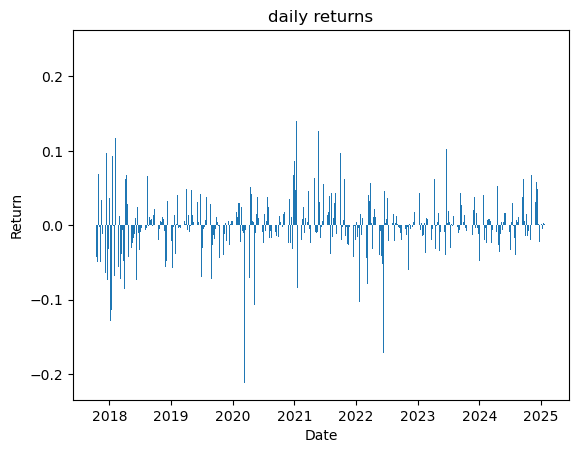

"\nplt.bar(fruits, sales)\nplt.title('Fruit Sales')\n\n\n"

In [15]:
plt.bar(BTC_df['Date'], BTC_df['return'])
plt.title('daily returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()


                              

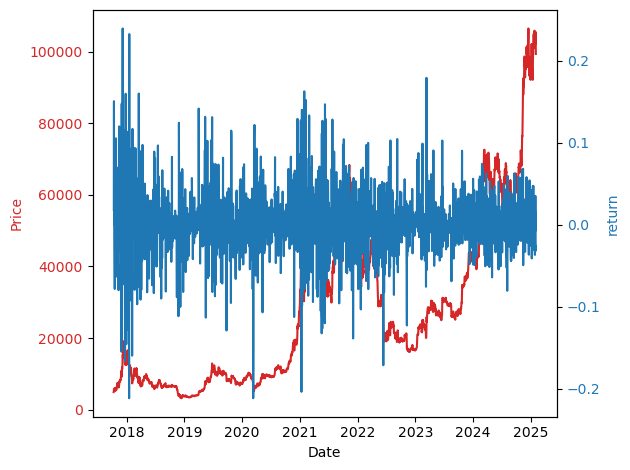

In [22]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='tab:red')
ax1.plot(BTC_df['Date'], BTC_df['close'], color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  

ax2.set_ylabel('return', color='tab:blue')  
ax2.plot(BTC_df['Date'], BTC_df['return'], color="tab:blue")
ax2.tick_params(axis='y', labelcolor="tab:blue")

fig.tight_layout()  
plt.show()


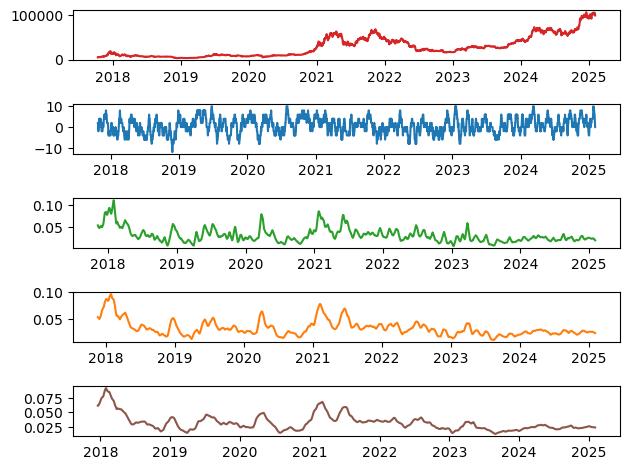

In [29]:
fig, axis = plt.subplots(5,1)

axis[0].plot(BTC_df['Date'], BTC_df['close'], color="tab:red")
axis[1].plot(BTC_df['Date'], BTC_df['rtrend14'], color="tab:blue")
axis[2].plot(BTC_df['Date'], BTC_df['avgvolty14'], color="tab:green")
axis[3].plot(BTC_df['Date'], BTC_df['avgvolty28'], color="tab:orange")
axis[4].plot(BTC_df['Date'], BTC_df['avgvolty56'], color="tab:brown")

fig.tight_layout()  

plt.show()
#https://www.geeksforgeeks.org/plot-multiple-plots-in-matplotlib/

In [4]:
#Assign Markov State
#https://www.statology.org/pandas-create-new-column-based-on-multiple-condition-if-else/
BTC_df = BTCUSDT_data[112:].copy()

markov_conditions = [
    (abs(BTC_df['rtrend28'])<5) & (BTC_df['std']>BTC_df['avgvolty56']) & (abs(BTC_df['ma07'] - BTC_df['ma14'])/BTC_df['ma07']<0.5), #rangebound/consolidating,
    (abs(BTC_df['rtrend28'])>7) & (abs(BTC_df['rtrend07'])>5) & (BTC_df['std']<BTC_df['avgvolty56']) & (BTC_df['ma07'] > BTC_df['ma14'] ) #trending,)
]

results = ["RANGEBOUND", "TRENDING"]

BTC_df["markov_state"] = np.select(markov_conditions, results)

BTC_df.head(50)


timestamp     open     high      low    close  \
112  2018-01-30 16:00:07.168  10334.4  10515.0   9712.0  10028.9   
113  2018-01-31 15:59:43.616  10028.9  10300.0   9268.0   9341.5   
114  2018-02-01 15:59:20.064   9341.5   9539.9   8050.0   9072.0   
115  2018-02-02 15:58:56.512   9076.5   9473.1   8260.0   9188.9   
116  2018-02-03 16:00:44.032   9188.9   9470.6   8450.0   8837.6   
117  2018-02-04 16:00:20.480   8837.6   8837.6   7222.0   7424.6   
118  2018-02-05 15:59:56.928   7424.6   7511.3   6032.3   7310.1   
119  2018-02-06 15:59:33.376   7310.1   8499.9   6810.0   8165.4   
120  2018-02-07 15:59:09.824   8165.4   8700.8   7400.0   8245.1   
121  2018-02-08 16:00:57.344   8244.0   8494.0   7760.0   8364.0   
122  2018-02-09 16:00:33.792   8363.6   9036.7   8269.8   8311.9   
123  2018-02-10 16:00:10.240   8301.0   8569.4   7820.2   8426.0   
124  2018-02-11 15:59:46.688   8426.0   8838.0   8024.0   8640.0   
125  2018-02-12 15:59:23.136   8650.5   8976.8   8360.0   8500.0   
126  2018-02-13 15:58:59.584   8504.9   9307.3   8474.3   9300.0   
127  2018-02-14 16:00:47.104   9307.3   9897.0   9182.2   9788.9   
128  2018-02-15 16:00:23.552   9774.0  10274.9   9663.3  10009.3   
129  2018-02-16 16:00:00.000  10016.9  10860.0   9888.0  10709.0   
130  2018-02-17 15:59:36.448  10716.1  11249.0  10112.0  10594.7   
131  2018-02-18 15:59:12.896  10594.7  11230.0  10302.0  11187.9   
132  2018-02-19 16:01:00.416  11183.0  11649.9  10900.0  11497.4   
133  2018-02-20 16:00:36.864  11497.4  11774.0  10410.0  10583.0   
134  2018-02-21 16:00:13.312  10555.8  10919.2   9750.0   9990.0   
135  2018-02-22 15:59:49.760  10004.6  10400.0   9560.0  10310.1   
136  2018-02-23 15:59:26.208  10300.1  10495.0   9570.0   9731.5   
137  2018-02-24 15:59:02.656   9739.6   9839.7   9285.0   9399.9   
138  2018-02-25 16:00:50.176   9378.5  10360.6   9291.9  10277.9   
139  2018-02-26 16:00:26.624  10277.9  10874.3  10129.8  10583.7   
140  2018-02-27 16:00:03.072  10589.4  11070.0  10372.0  10507.7   
141  2018-02-28 15:59:39.520  10501.5  10845.6  10233.0  10717.6   
142  2018-03-01 15:59:15.968  10702.8  11188.1  10681.6  10854.9   
143  2018-03-02 16:01:03.488  10854.9  11497.9  10778.9  11479.9   
144  2018-03-03 16:00:39.936  11479.9  11520.0  11067.5  11133.3   
145  2018-03-04 16:00:16.384  11133.3  11619.9  11107.5  11505.8   
146  2018-03-05 15:59:52.832  11499.3  11684.6  10804.7  10972.5   
147  2018-03-06 15:59:29.280  10963.9  10998.8  10410.0  10663.9   
148  2018-03-07 15:59:05.728  10669.4  10706.1   9411.6   9892.5   
149  2018-03-08 16:00:53.248   9894.4   9899.0   8350.0   8931.7   
150  2018-03-09 16:00:29.696   8931.7   9487.9   8650.0   9359.9   
151  2018-03-10 16:00:06.144   9351.6   9423.8   8446.3   9062.7   
152  2018-03-11 15:59:42.592   9072.8   9890.0   9062.7   9177.9   
153  2018-03-12 15:59:19.040   9178.0   9489.0   8763.8   9071.1   
154  2018-03-13 15:58:55.488   9078.8   9344.0   8580.0   8719.5   
155  2018-03-14 16:00:43.008   8723.9   8724.9   7670.0   8109.7   
156  2018-03-15 16:00:19.456   8100.0   8600.0   7906.5   8540.0   
157  2018-03-16 15:59:55.904   8536.6   8581.7   7847.1   7889.9   
158  2018-03-17 15:59:32.352   7888.6   8052.0   7319.0   7380.8   
159  2018-03-18 15:59:08.800   7390.0   8683.0   7325.8   8562.9   
160  2018-03-19 16:00:56.320   8560.6   8659.0   8251.0   8512.9   
161  2018-03-20 16:00:32.768   8512.9   9178.9   8510.0   9042.1   

           volume    volume_ccy   volCcyQuote  confirm  \
112  13105.573827  1.329906e+08  1.329906e+08        1   
113  12126.036741  1.187990e+08  1.187990e+08        1   
114  24088.322765  2.119027e+08  2.119027e+08        1   
115  13157.413721  1.164154e+08  1.164154e+08        1   
116   9035.343303  8.167515e+07  8.167515e+07        1   
117  22587.150991  1.793289e+08  1.793289e+08        1   
118  45609.867349  3.071916e+08  3.071916e+08        1   
119  28328.116584  2.135674e+08  2.135674e+08        1   
120   5234.161839  4.260795e

In [9]:

colors=[]
for val in BTC_df:
    if val=="RANGEBOUND":
        colors.append("blue")
    elif val=="TRENDING":
        colors.append("red")
    else:
        colors.append("black")
    
#colors=['blue' if val == "RANGEBOUND" elif else 'blue' for val in BTCUSDT_data['markov_state']]
trace = go.Scatter(
    x=BTCUSDT_data['Date'], 
    y=BTCUSDT_data['close'], 
    mode='markers+lines', 
    marker={'color': colors}, 
    line={'color': 'gray'}
)

fig = go.Figure(data=trace)
fig.show()
"""
import itertools as it


# generate data
x = np.arange(0, 8*np.pi, 0.1)
y = np.sin(x)

# cutoff value
cutoff = 0

# create coordinate  pairs
x_pairs = it.pairwise(x)
y_pairs = it.pairwise(y)

# generate color list
colors=['red' if any([i < cutoff for i in y_values]) else 'blue' for y_values in it.pairwise(y)]

# create base figure
fig = go.Figure()

# add traces (line segments)
for x, y, color in zip(x_pairs, y_pairs, colors):
    fig.add_trace(
        go.Scatter(
            x=x,
            y=y, 
            mode='lines', 
            line={'color': color}
        )
    )
    
fig.update_layout(showlegend=False)
"""



"\nfig = go.Figure(data=go.Ohlc(x=BTCUSDT_data['Date'], \n                             open=BTCUSDT_data['open'], \n                             high=BTCUSDT_data['high'], \n                             low=BTCUSDT_data['low'], \n                             close=BTCUSDT_data['close'])) \n  \nfig.show() \n"

In [14]:
BTC_markovdf = BTC_df.set_index('markov_state', append=True)['close']
mdf = BTC_markovdf.unstack('markov_state')
mdf.tail(50)


markov_state         0  RANGEBOUND  TRENDING
2622          102696.9         NaN       NaN
2623          106319.9         NaN       NaN
2624          106471.0         NaN       NaN
2625          104427.3         NaN       NaN
2626          100676.1         NaN       NaN
2627               NaN     96989.3       NaN
2628               NaN     97524.1       NaN
2629               NaN     95370.9       NaN
2630               NaN     93256.3       NaN
2631               NaN     98306.8       NaN
2632               NaN     98532.9       NaN
2633               NaN     96039.7       NaN
2634               NaN     94576.5       NaN
2635               NaN     94444.1       NaN
2636           94505.4         NaN       NaN
2637           92123.0         NaN       NaN
2638               NaN     95417.8       NaN
2639           94442.9         NaN       NaN
2640           96476.5         NaN       NaN
2641           97524.4         NaN       NaN
2642           97665.3         NaN       NaN
2643           98029.8         NaN       NaN
2644          102149.4         NaN       NaN
2645           97942.8         NaN       NaN
2646           95481.4         NaN       NaN
2647           94247.1         NaN       NaN
2648           93734.9         NaN       NaN
2649           94413.0         NaN       NaN
2650           95073.9         NaN       NaN
2651           92123.5         NaN       NaN
2652               NaN     96475.7       NaN
2653               NaN     98985.9       NaN
2654               NaN     99299.9       NaN
2655               NaN    104013.6       NaN
2656               NaN    104561.4       NaN
2657          104933.5         NaN       NaN
2658          104940.7         NaN       NaN
2659          103954.2         NaN       NaN
2660          104188.0         NaN       NaN
2661          105272.7         NaN       NaN
2662          105862.2         NaN       NaN
2663          104897.2         NaN       NaN
2664          104972.6         NaN       NaN
2665          101101.3         NaN       NaN
2666          102776.8         NaN       NaN
2667          101975.5         NaN       NaN
2668          105564.0         NaN       NaN
2669          105438.0         NaN       NaN
2670          102074.3         NaN       NaN
2671           99348.2         NaN       NaN

<AxesSubplot:>

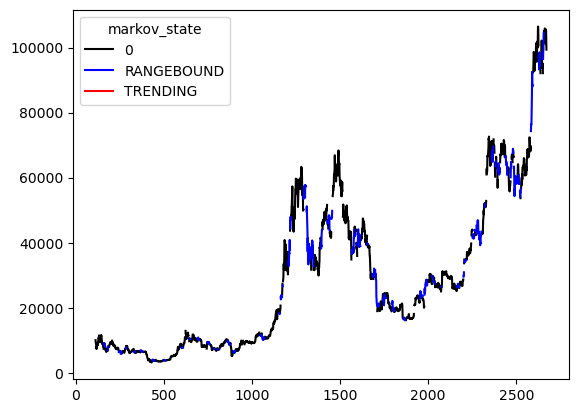

In [16]:
colors_map = {'RANGEBOUND': 'b',
              'TRENDING': 'red',
              '0': 'black'}
mdf.plot(color=colors_map)

In [51]:
#need to add choppiness index 
#https://www.insightbig.com/post/detecting-ranging-and-trending-markets-with-choppiness-index-in-python

#use a classification algorithm to decide the rangebound/trending criteria after manually tagging


BTC_mm = pd.read_csv('20250202 12.58.42.-20170908 12.58.42._BTC-USDT_1D_okx_ohlc_M.csv')
BTC_mm_plot = BTC_mm.set_index('m_long3', append=True)['close']
BTC_mm_plot = BTC_mm_plot.unstack('markov_state_man')
colors_map = {'RANGEBOUND': 'b',
              'TRENDING': 'red',
              'SIDEWAYS': 'green',
              '0': 'black'}
BTC_mm_plot['date'] = BTCUSDT_data['Date']

#plot.rcParams['figure.figsize'] = [200, 200]
BTC_mm_plot.plot(color=colors_map)

#BTC_mm_plot.head(50)


KeyError: 'Level markov_state_man not found'

<AxesSubplot:>

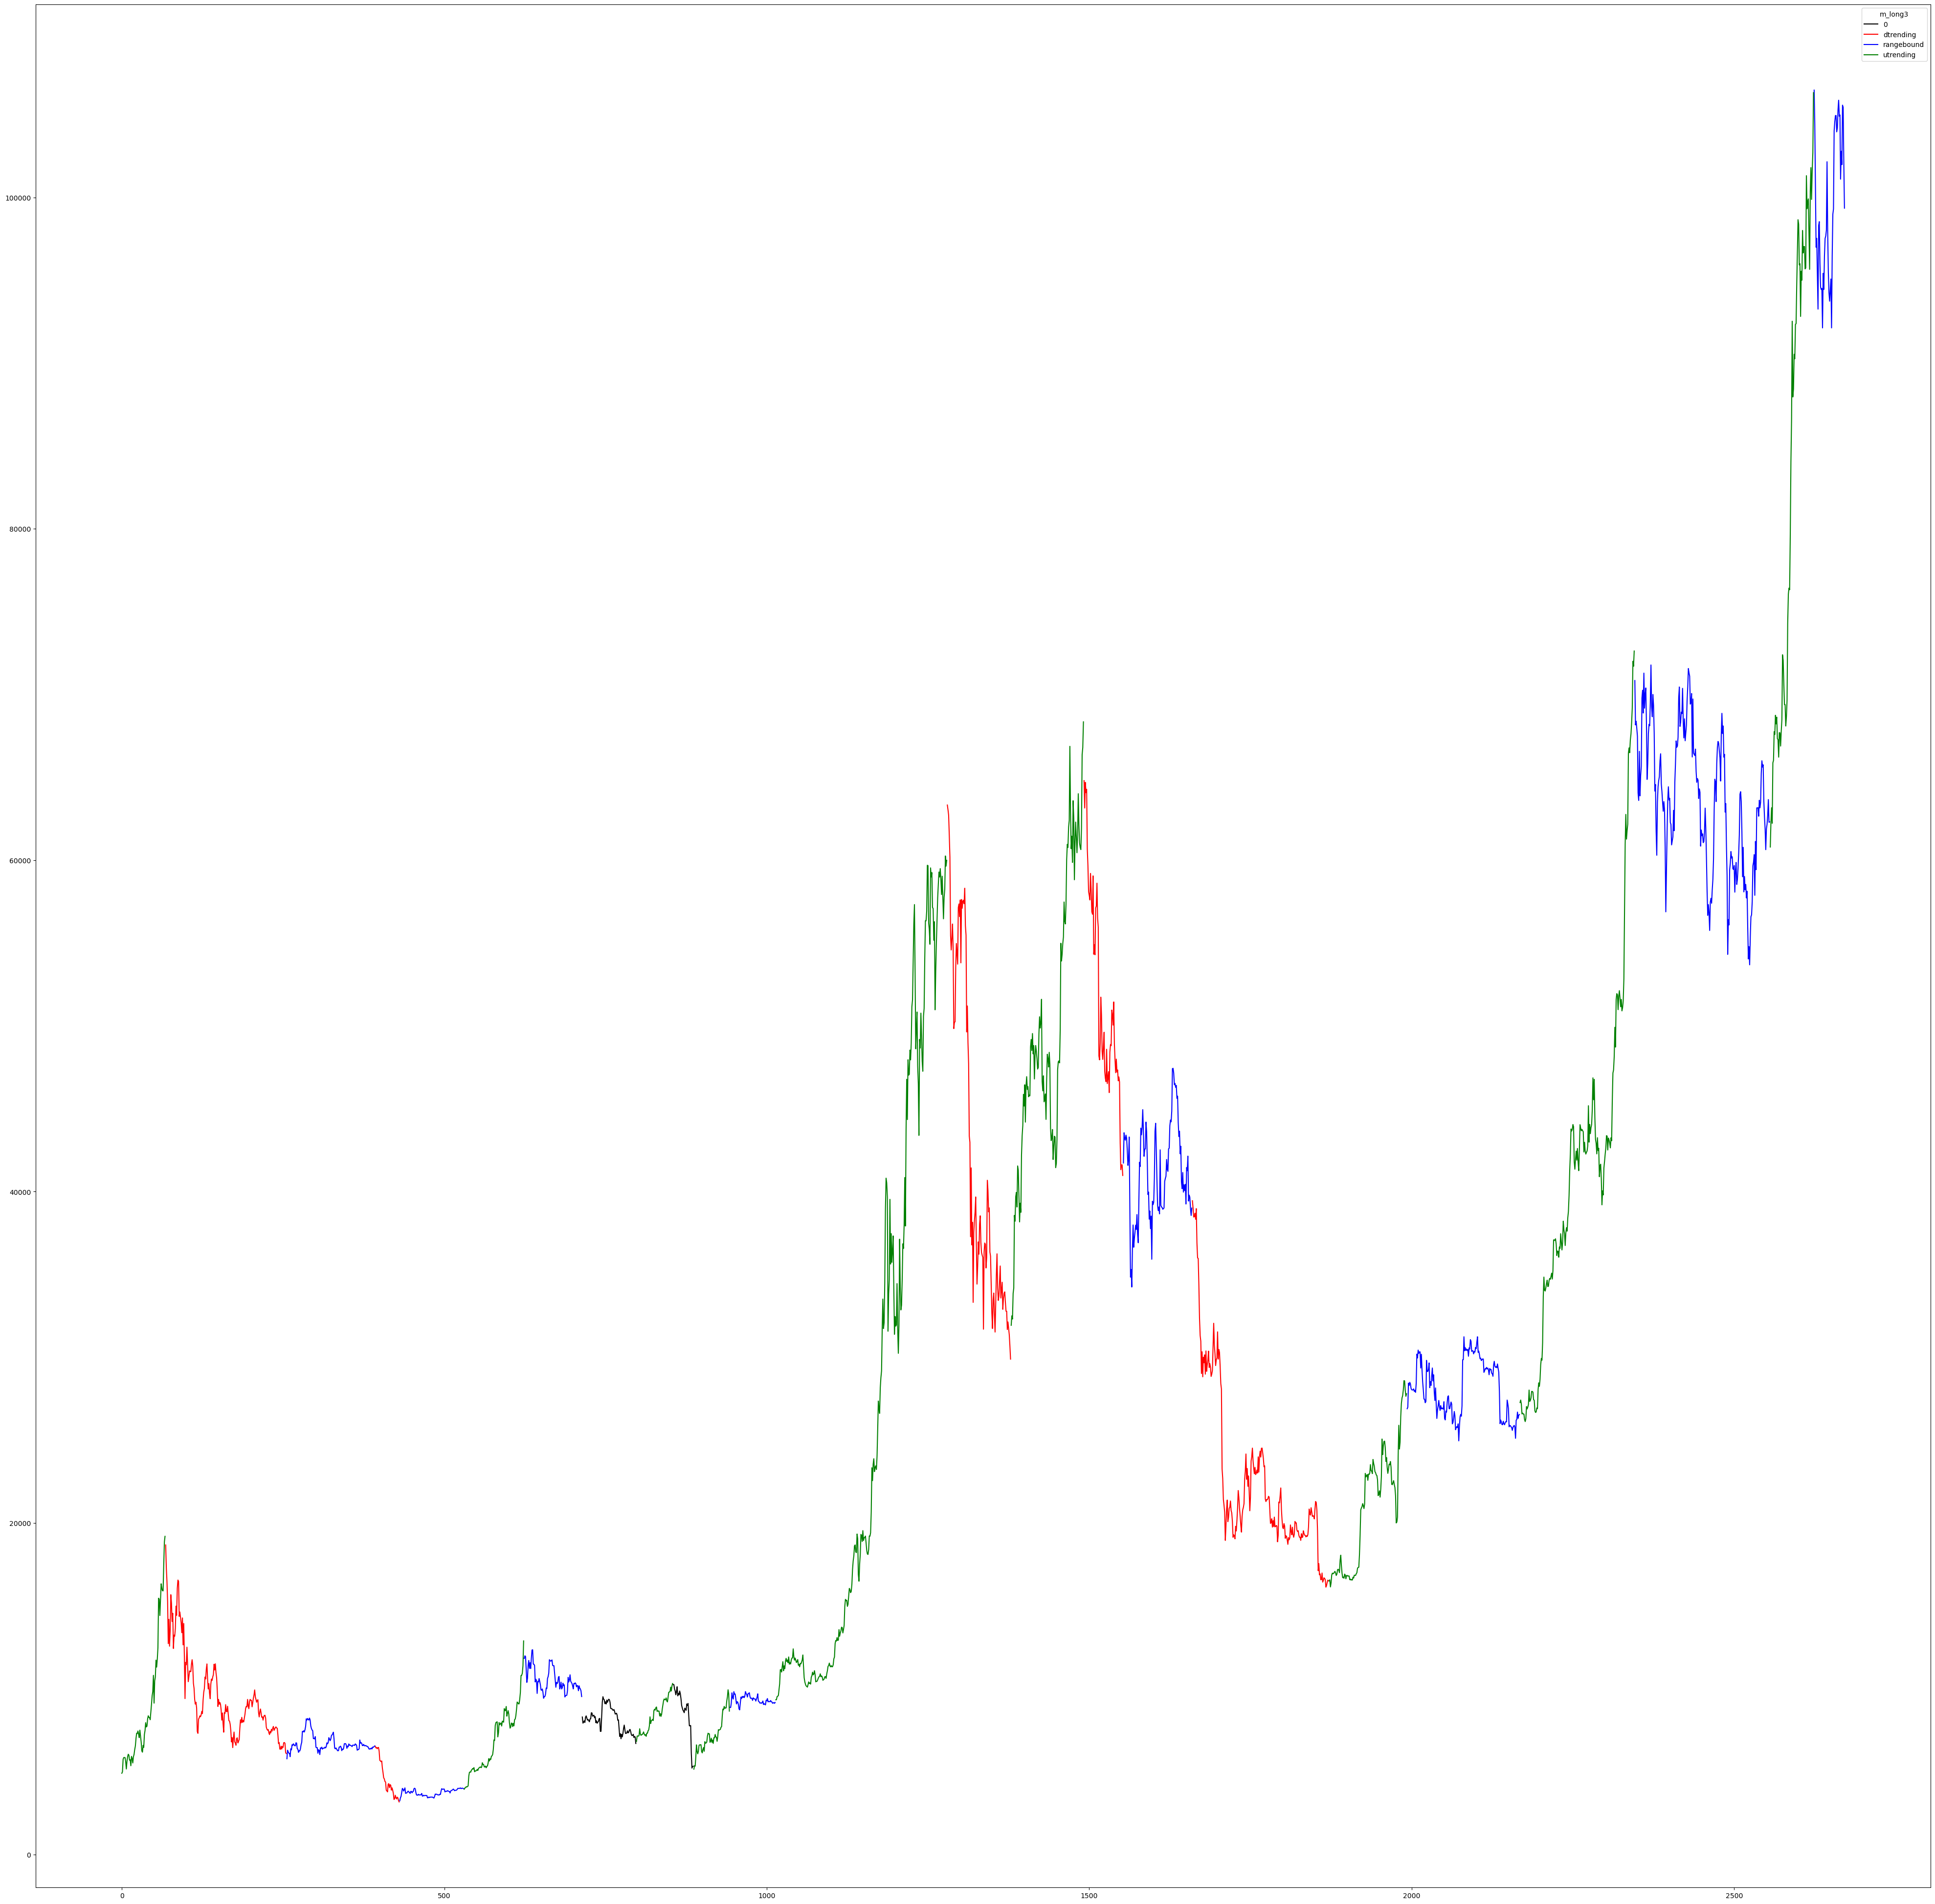

In [2]:
#need to add choppiness index 
#https://www.insightbig.com/post/detecting-ranging-and-trending-markets-with-choppiness-index-in-python

#use a classification algorithm to decide the rangebound/trending criteria after manually tagging


BTC_mm = pd.read_csv('20250202 12.58.42.-20170908 12.58.42._BTC-USDT_1D_okx_ohlc_M.csv')
BTC_mm_long3 = BTC_mm.set_index('m_long3', append=True)['close']
BTC_mm_long3 = BTC_mm_long3.unstack('m_long3')
colors_map = {'rangebound': 'b',
              'dtrending': 'red',
              'utrending': 'green',
              '0': 'black'}
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
BTC_mm_long3.plot(color=colors_map)

#BTC_mm_plot.head(50)

In [ ]:
#classification algorithms 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [7]:
#DOGE_mm = pd.read_csv('20250202 12.58.42.-20170908 12.58.42._DOGE-USDT_1D_okx_ohlc_M.csv') 
DOGE_mm = pd.read_csv('20250202 12.58.42.-20170908 12.58.42._XRP-USDT_1D_okx_ohlc_M.csv')


#BTC_mm_plot.head(50)

<AxesSubplot:>

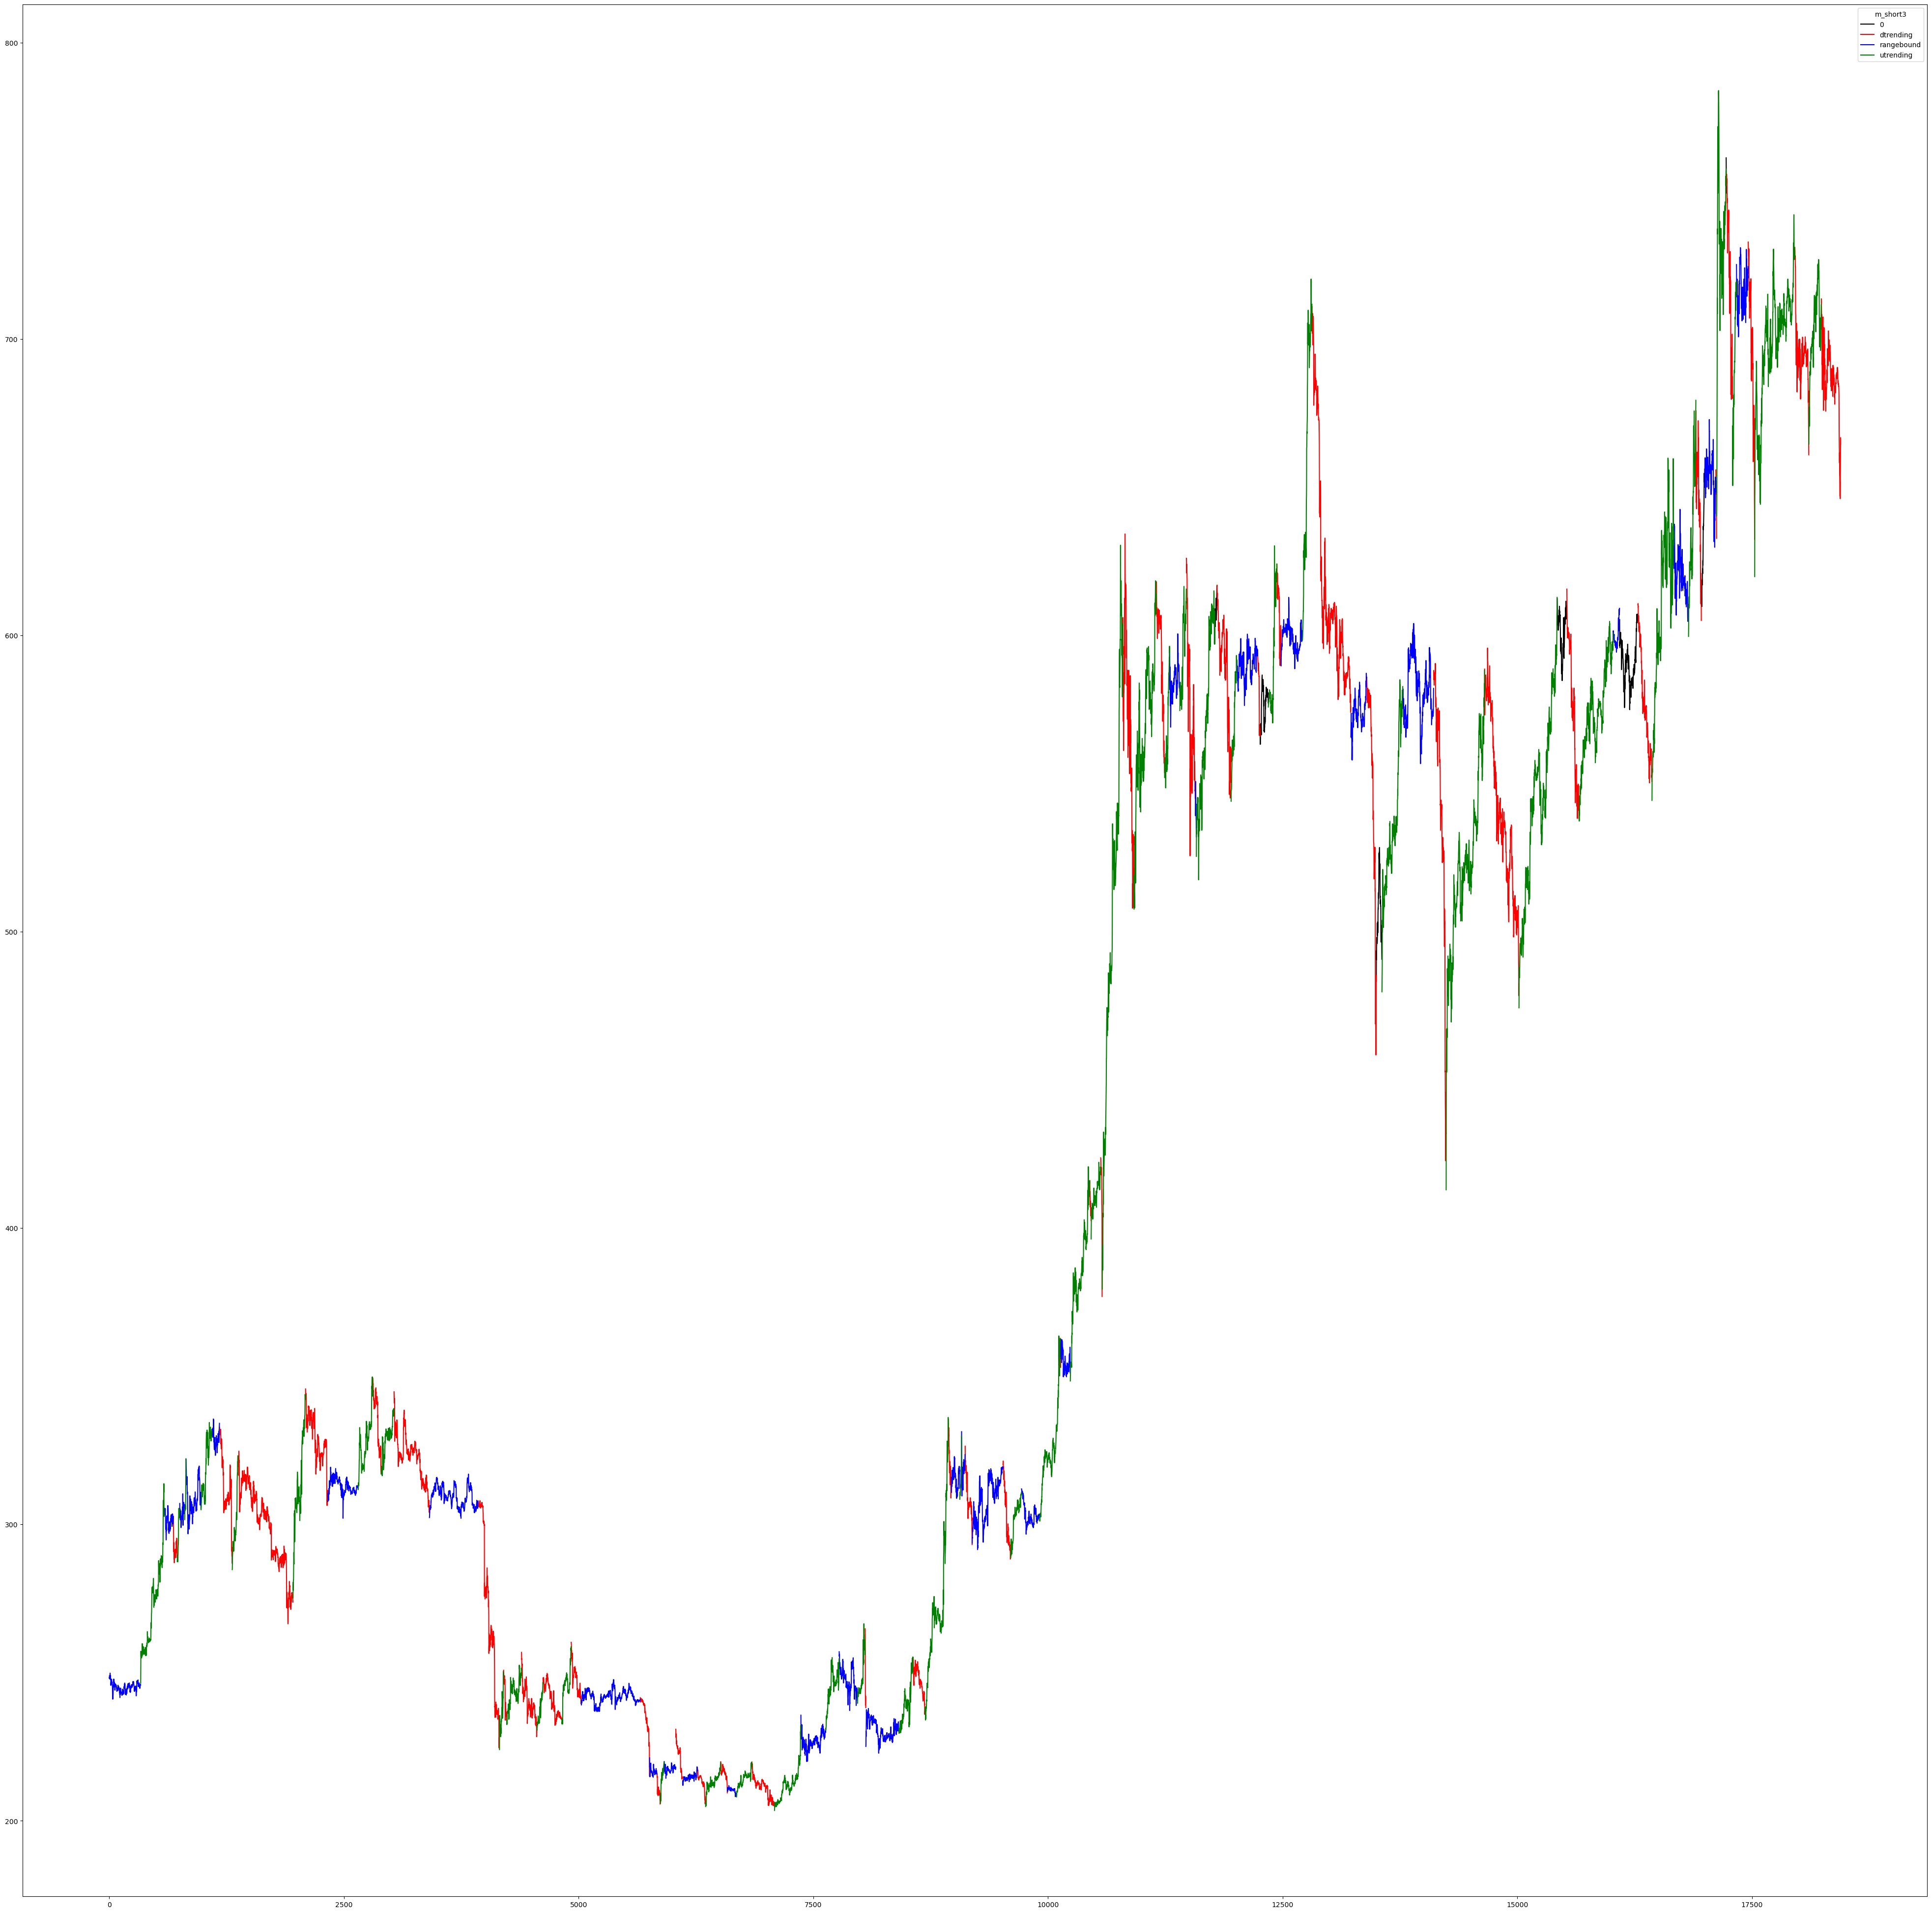

In [76]:
DOGE_mm = pd.read_csv('2025-01-27 23.34.10.711000-2017-09-07 23.34.10.711000_BNB-USDT_1H_ohlc_M.csv')
DOGE_mm_long3 = DOGE_mm.set_index('m_short3', append=True)['close']
DOGE_mm_long3 = DOGE_mm_long3.unstack('m_short3')
colors_map = {'rangebound': 'b',
              'dtrending': 'red',
              'utrending': 'green',
              '0': 'black'}
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
DOGE_mm_long3.plot(color=colors_map)

#need to add ratios of ohlc/range in here 